In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

from tabulate import tabulate

import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl

# start auto-reloading certain libraries marked with %aimport
%load_ext autoreload
%autoreload 1
# add new source file to auto-reload
%aimport capstone_2
# add function from auto-reloading module
import capstone_2 as cap

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [4]:
# Import Dataset
df_info, df_scripts = cap.load_data()
df_docs_by_ep = cap.agg_dialogue_by_episode(df_scripts, df_info)

In [5]:
df_info.head(200)

,Season,EpisodeNo,Title,AirDate,Writers,Director,SEID,IMDB_Rating
OverallEPNo,,,,,,,,
0,1,0,"Good News, Bad News",5-Jul-89,"Larry David, Jerry Seinfeld",Art Wolff,S01E00,7.7
1,1,1,The Stakeout,31-May-90,"Larry David, Jerry Seinfeld",Tom Cherones,S01E01,7.7
2,1,2,The Robbery,7-Jun-90,Matt Goldman,Tom Cherones,S01E02,7.7
3,1,3,Male Unbonding,14-Jun-90,"Larry David, Jerry Seinfeld",Tom Cherones,S01E03,7.5
4,1,4,The Stock Tip,21-Jun-90,"Larry David, Jerry Seinfeld",Tom Cherones,S01E04,7.7
5,2,1,The Ex-Girlfriend,16-Jan-91,"Larry David, Jerry Seinfeld",Tom Cherones,S02E01,7.8
6,2,2,The Pony Remark,30-Jan-91,"Larry David, Jerry Seinfeld",Tom Cherones,S02E02,8.0
7,2,3,The Jacket,6-Feb-91,"Larry David, Jerry Seinfeld",Tom Cherones,S02E03,8.4
8,2,4,The Phone Message,13-Feb-91,"Larry David, Jerry Seinfeld",Tom Cherones,S02E04,8.5


In [6]:
df_scripts.head(3)

,Character,Dialogue,EpisodeNo,SEID,Season
0,JERRY,Do you know what this is all about? Do you kno...,0.0,S01E00,1.0
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,S01E00,1.0
2,GEORGE,Are you through?,0.0,S01E00,1.0


In [7]:
main_characters = ['JERRY', 'GEORGE', 'ELAINE', 'KRAMER']
more_characters = ['JERRY', 'GEORGE', 'ELAINE', 'KRAMER', 'NEWMAN', 'MORTY', 'HELEN', 'FRANK']

In [29]:
def lines_per_season(df_scripts):
    df = df_scripts.copy()
    
    # Group by Season and Character to count total lines per character per season
    df_lines_per_season = df.groupby(['Season', 'Character'], as_index=False).Dialogue.count()
    print(df_lines_per_season.head(5))
    
    # Sum lines per season to get total values so can calculate fraction
    total_lines_per_season = df_lines_per_season.groupby('Season').Dialogue.sum()
    
    # Join lines per season with total lines
    df_lines_per_season = df_lines_per_season.merge(pd.DataFrame(total_lines_per_season),
                                        left_on='Season',
                                        right_index=True)
    
    df_lines_per_season.columns = ['Season', 'Character', 'Lines',
                             'Lines_in_Season']
    
    # Calcualte % of total lines/season by character
    df_lines_per_season['Percent_of_Total_Lines'] = (df_lines_per_season.Lines /
                                      df_lines_per_season.Lines_in_Season)

    return df_lines_per_season

df_line_counts = lines_per_season(df_scripts)
df_line_counts[df_line_counts['Character']==main_characters[0]].head(10)                                         

   Season                                          Character  Dialogue
0     1.0  (George shows his note-block to Jerry; it says...         1
1     1.0                                              ARTIE         4
2     1.0                                           AUDIENCE         1
3     1.0                                               BOTH         4
4     1.0                                              CAROL        12


,Season,Character,Lines,Lines_in_Season,Percent_of_Total_Lines
18,1.0,JERRY,564,1308,0.431193
88,2.0,JERRY,1059,3077,0.344166
216,3.0,JERRY,2001,6811,0.293789
493,4.0,JERRY,2094,7285,0.287440
764,5.0,JERRY,1821,7228,0.251937
1069,6.0,JERRY,1834,6903,0.265682
1367,7.0,JERRY,1858,7806,0.238022
1668,8.0,JERRY,1762,6895,0.255547
1961,9.0,JERRY,1793,7293,0.245852


In [9]:
# QA to make sure Total Jerry lines match
jerry_lines_df_lines_Total = df_line_counts[df_line_counts['Character']==main_characters[0]].Lines.sum()
jerry_lines_df_scripts_Total = df_scripts[df_scripts.Character=='JERRY'].Dialogue.count()
jerry_lines_df_lines_Total == jerry_lines_df_scripts_Total

True

In [10]:
df_line_counts.head(5)

,Season,Character,Lines,Lines_in_Season,Percent_of_Total_Lines
0,1.0,(George shows his note-block to Jerry; it says...,1,1308,0.000765
1,1.0,ARTIE,4,1308,0.003058
2,1.0,AUDIENCE,1,1308,0.000765
3,1.0,BOTH,4,1308,0.003058
4,1.0,CAROL,12,1308,0.009174


In [11]:
cmap_options = ['Set1', 'Set2', 'Set3', 'tab10']

def create_colormap(cmap_name, chars):
    cmap = mpl.cm.get_cmap(cmap_name)
    
    cmap_dict = {}
    for i in range(len(chars)):
        character = chars[i]
        cmap_dict[character] = cmap(i)

    return cmap_dict

    
mpl.cm.get_cmap(name='Set3')
mpl.colors.Colormap(name='Set3')
cmap = mpl.cm.get_cmap('Set3')
print(cmap(1))
main_char_colors = create_colormap('Set2', main_characters)
more_char_colors = create_colormap('Set2', more_characters)
#main_char_colors
more_char_colors

(1.0, 1.0, 0.7019607843137254, 1.0)


{'JERRY': (0.4, 0.7607843137254902, 0.6470588235294118, 1.0),
 'GEORGE': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961, 1.0),
 'ELAINE': (0.5529411764705883, 0.6274509803921569, 0.796078431372549, 1.0),
 'KRAMER': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411, 1.0),
 'NEWMAN': (0.6509803921568628, 0.8470588235294118, 0.32941176470588235, 1.0),
 'MORTY': (1.0, 0.8509803921568627, 0.1843137254901961, 1.0),
 'HELEN': (0.8980392156862745, 0.7686274509803922, 0.5803921568627451, 1.0),
 'FRANK': (0.7019607843137254, 0.7019607843137254, 0.7019607843137254, 1.0)}

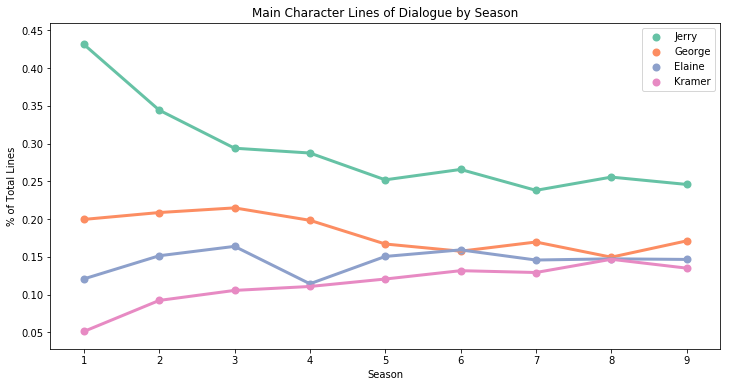

In [12]:
def plot_character_usage(df_line_counts):
    df = df_line_counts.copy()
    
    fig = plt.figure(figsize=(12,6))
    
    for character in main_characters:
        mpl.rc('image', cmap='Set3')
        
        plt.cmap = "Set3"
        character_df = df[df['Character'] == character]
        x = character_df['Season']
        y = character_df['Percent_of_Total_Lines']
        
        # mpl.rcParams['axes.color_cycle']
        plt.scatter(x, y, label=character.title(), color=main_char_colors[character], lw=2)
        plt.plot(x, y, label='_nolegend_', color=main_char_colors[character], lw=3)

    
    #ax = sns.lineplot(y, x, palette="Set3", hue='Character', data=df_character)
    
    plt.ylabel('% of Total Lines')
    plt.xlabel('Season')
    plt.legend()
    plt.title('Main Character Lines of Dialogue by Season', loc='center')
    plt.show()

plot_character_usage(df_line_counts)

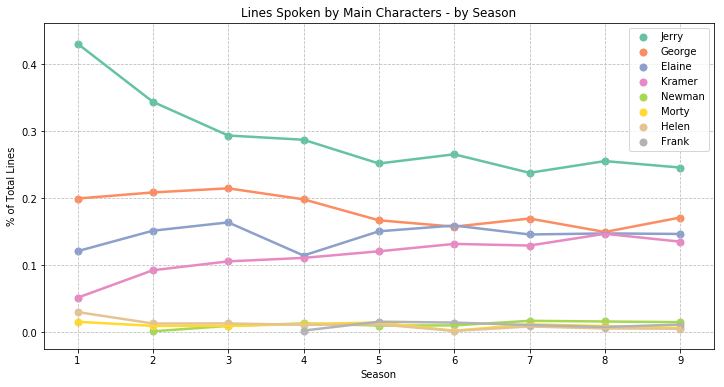

In [13]:
def plot_character_usage_more(df_line_counts):
    df = df_line_counts.copy()
    
    fig = plt.figure(figsize=(12,6))
    
    for character in more_characters:
        mpl.rc('image', cmap='Set3')
        
        plt.cmap = "Set3"
        character_df = df[df['Character'] == character]
        x = character_df['Season']
        y = character_df['Percent_of_Total_Lines']
        
        # mpl.rcParams['axes.color_cycle']
        plt.scatter(x, y, label=character.title(), color=more_char_colors[character], lw=2)
        plt.plot(x, y, label='_nolegend_', color=more_char_colors[character], lw=2.5)

    
    #ax = sns.lineplot(y, x, palette="Set3", hue='Character', data=df_character)
    
    plt.ylabel('% of Total Lines')
    plt.xlabel('Season')
    plt.legend()
    plt.title('Lines Spoken by Main Characters - by Season', loc='center')
    plt.grid(linestyle="--", color=(0.75, 0.75, 0.75, 0.1))
    plt.show()

plot_character_usage_more(df_line_counts)

In [14]:
df_docs_by_ep.head()

,Dialogue,Lines_of_Dialogue,SEID,Season,Episode,Title,AirDate,Writers,Director,IMDB_Rating
0,Do you know what this is all about? Do you kno...,211,S01E00,1.0,0.0,"Good News, Bad News",5-Jul-89,"Larry David, Jerry Seinfeld",Art Wolff,7.7
1,"So, Im on line at the supermarket. Two women i...",346,S01E01,1.0,1.0,The Stakeout,31-May-90,"Larry David, Jerry Seinfeld",Tom Cherones,7.7
2,"So I move into the centre lane, now I get ahea...",280,S01E02,1.0,2.0,The Robbery,7-Jun-90,Matt Goldman,Tom Cherones,7.7
3,"Most men like working on things. Tools, object...",241,S01E03,1.0,3.0,Male Unbonding,14-Jun-90,"Larry David, Jerry Seinfeld",Tom Cherones,7.5
4,Went out to dinner the other night. Check came...,230,S01E04,1.0,4.0,The Stock Tip,21-Jun-90,"Larry David, Jerry Seinfeld",Tom Cherones,7.7


In [15]:
main_writers = ['Larry David', 'Larry David, Jerry Seinfeld', 'Larry Charles', 
                'Peter Mehlman', 'Tom Gammill, Max Pross', 'Gregg Kavet, Andy Robin',
               'Alec Berg, Jeff Schaffer', 'Spike Feresten ', 'Jennifer Crittenden']

In [16]:
len(df_docs_by_ep.Dialogue[25])

14488

In [17]:
def writers_per_season(df_docs_by_ep):
    df = df_docs_by_ep.copy()
    
    # Group by Season and Writers to count total lines per character per season
    df_eps_per_writer = df.groupby(['Season', 'Writers'], as_index=False).Episode.count()
    
    # Sum episodes per season to get total values so can calculate fraction
    total_eps_per_season = df_eps_per_writer.groupby('Season').Episode.sum()
    
    # Join episdoes per season with writers
    df_eps_per_writer = df_eps_per_writer.merge(pd.DataFrame(total_eps_per_season),
                                        left_on='Season',
                                        right_index=True)
    
    df_eps_per_writer.columns = ['Season', 'Writers', 'Episodes_Written',
                             'Episodes_in_Season']
    
    # Calcualte % of total episodes/season by writer
    df_eps_per_writer['Percent_of_Total_Episodes'] = (df_eps_per_writer.Episodes_Written /
                                      df_eps_per_writer.Episodes_in_Season)

    return df_eps_per_writer

df_eps_per_writer = writers_per_season(df_docs_by_ep)
df_eps_per_writer.head(100)

,Season,Writers,Episodes_Written,Episodes_in_Season,Percent_of_Total_Episodes
0,1.0,"Larry David, Jerry Seinfeld",4,5,0.800000
1,1.0,Matt Goldman,1,5,0.200000
2,2.0,Larry Charles,3,12,0.250000
3,2.0,Larry David,2,12,0.166667
4,2.0,"Larry David, Jerry Seinfeld",6,12,0.500000
5,2.0,Peter Mehlman,1,12,0.083333
6,3.0,Elaine Pope,1,23,0.043478
7,3.0,"Elaine Pope, Larry Charles",1,23,0.043478
8,3.0,Larry Charles,2,23,0.086957
9,3.0,Larry Charles / Story By Marc Jaffe,1,23,0.043478


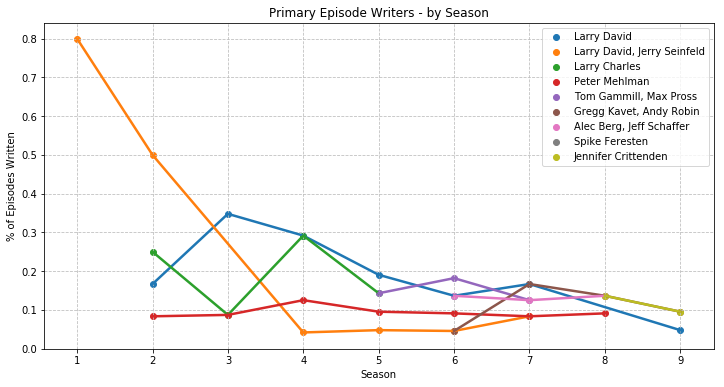

In [18]:
def plot_writers(df_eps_per_writer):
    df = df_eps_per_writer.copy()
    
    fig = plt.figure(figsize=(12,6))
    
    for writers in main_writers:
        character_df = df[df['Writers'] == writers]
        x = character_df['Season']
        y = character_df['Percent_of_Total_Episodes']
        
        plt.scatter(x, y, label=writers.title())
        plt.plot(x, y, label='_nolegend_', lw=2.5)

    plt.grid(linestyle="--", color=(0.75, 0.75, 0.75, 0.1))
    plt.ylabel('% of Episodes Written')
    plt.xlabel('Season')
    plt.legend()
    plt.title('Primary Episode Writers - by Season', loc='center')
    plt.show()

plot_writers(df_eps_per_writer)

In [19]:
df_eps_per_writer[df_eps_per_writer.Writers.str.contains("Alec")]
df_eps_per_writer.iloc[77, 1] = 'Alec Berg, Jennifer Crittenden, Spike Feresten and Others'

In [20]:
df_eps_per_writer[df_eps_per_writer.Writers=='Larry David'].Episodes_Written.sum()

29

In [21]:
df_eps_per_writer_sum = df_eps_per_writer.groupby(['Writers']).Episodes_Written.sum().reset_index()
df_eps_per_writer_sum  = df_eps_per_writer_sum.sort_values(by='Episodes_Written', ascending=False)
df_eps_per_writer_sum

,Writers,Episodes_Written
23,Larry David,29
29,"Larry David, Jerry Seinfeld",15
21,Larry Charles,15
37,Peter Mehlman,14
48,"Tom Gammill, Max Pross",10
19,"Gregg Kavet, Andy Robin",10
1,"Alec Berg, Jeff Schaffer",9
42,Spike Feresten,8
20,Jennifer Crittenden,5
43,Steve Koren,4


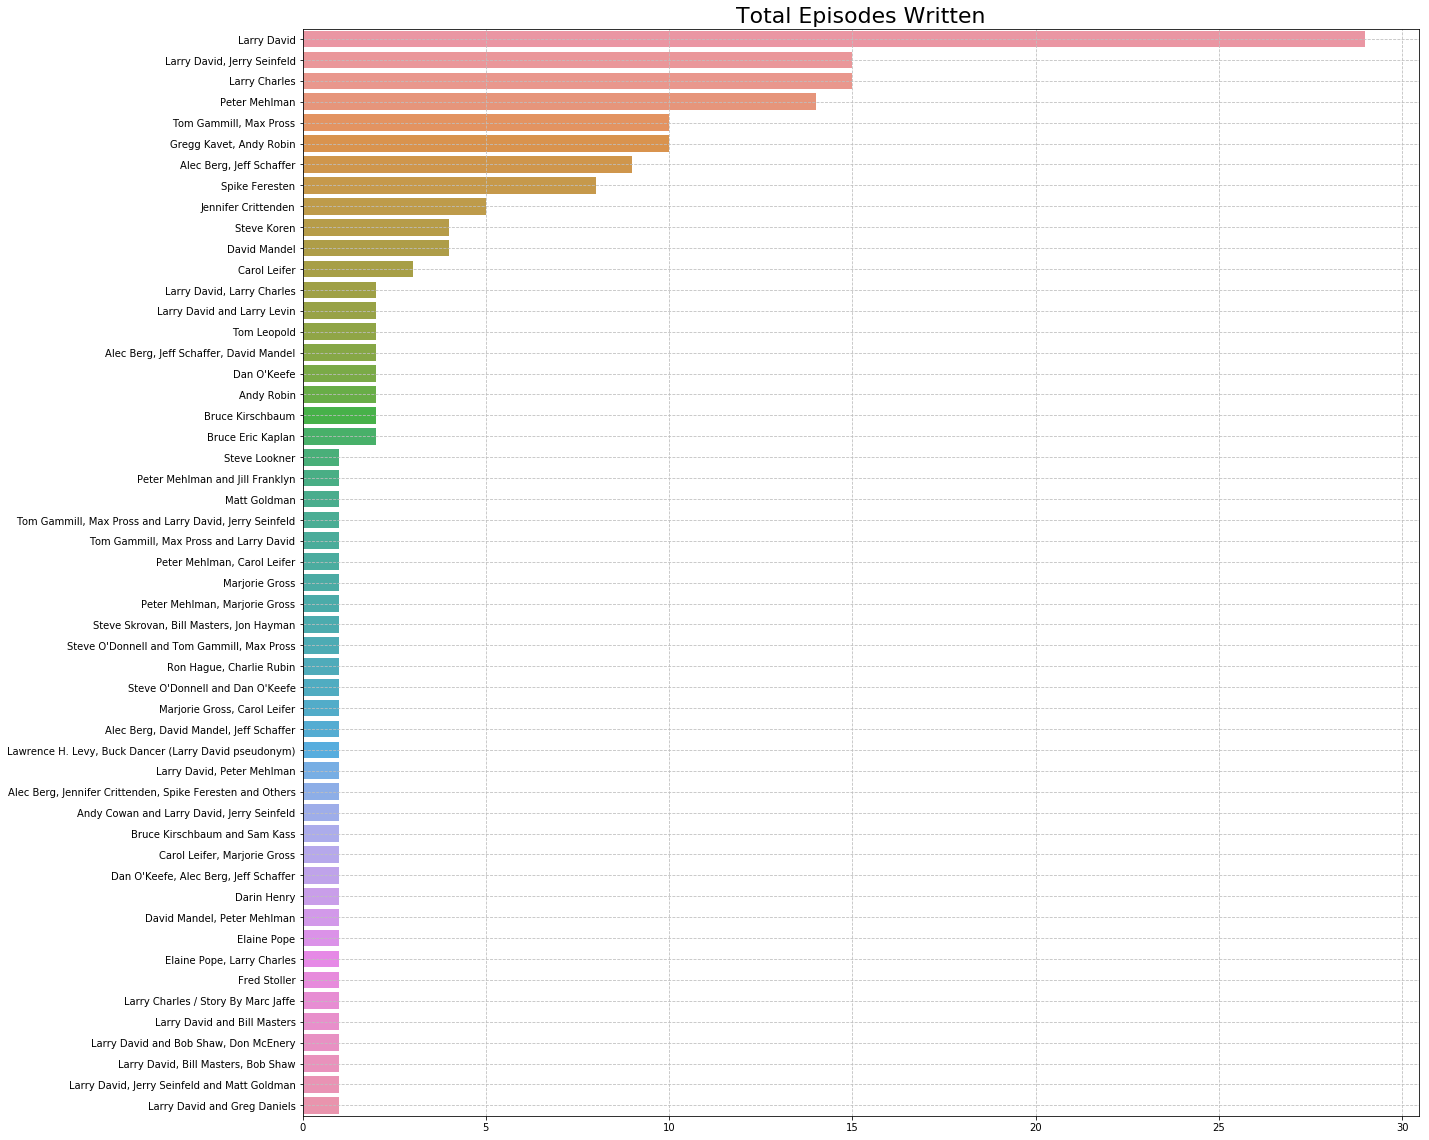

In [22]:
fig = plt.figure(figsize=(20,20))
plt.title("Total Episodes Written", fontsize=22)
ax = sns.barplot(x='Episodes_Written', y='Writers', data=df_eps_per_writer_sum,ci=None)
ax.set_xlabel('')
ax.set_ylabel('')
plt.grid(linestyle="--", color=(0.75, 0.75, 0.75, 0.1))

In [23]:
df_docs_by_ep.Lines_of_Dialogue.sum()

54606

In [24]:
df_docs_by_ep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 10 columns):
Dialogue             174 non-null object
Lines_of_Dialogue    174 non-null int64
SEID                 174 non-null object
Season               174 non-null float64
Episode              174 non-null float64
Title                174 non-null object
AirDate              174 non-null object
Writers              174 non-null object
Director             174 non-null object
IMDB_Rating          36 non-null float64
dtypes: float64(3), int64(1), object(6)
memory usage: 13.7+ KB


In [25]:
def lines_per_season(df_docs_by_ep):
    df = df_docs_by_ep.copy()
    
    df['Script_Length'] = df.Dialogue.str.len()
    
    # Group by Season to count total lines of Dialogue
    df_lines_per_season = df.groupby(['Season'], as_index=False) \
                         .Lines_of_Dialogue.agg({'Average_Lines': np.mean, 
                                                 'Total_Lines': np.sum, 
                                                 'Number_of_Episodes': len})
    
    df_chars_per_season = df.groupby(['Season'], as_index=False) \
                         .Script_Length.agg({'Average_Chars': np.mean,
                                             'Total_Chars': np.sum})
    
#     print(df_lines_per_season.head(10))
#     print(df_chars_per_season.head(10))
    
    
    # Join lines_per_season per season with chars_per_season
    df_lines_chars_per_season = df_lines_per_season.merge(df_chars_per_season,
                                        left_on='Season',
                                        right_on='Season')
    
    return df_lines_chars_per_season

df_lines_per_season = lines_per_season(df_docs_by_ep)
df_lines_per_season.head(10)

,Season,Average_Lines,Total_Lines,Number_of_Episodes,Average_Chars,Total_Chars
0,1.0,261.600000,1308,5,17387.200000,86936
1,2.0,256.416667,3077,12,16429.416667,197153
2,3.0,296.130435,6811,23,15499.304348,356484
3,4.0,303.541667,7285,24,16513.333333,396320
4,5.0,344.190476,7228,21,18144.428571,381033
5,6.0,313.772727,6903,22,16514.227273,363313
6,7.0,325.250000,7806,24,16818.541667,403645
7,8.0,313.409091,6895,22,16300.272727,358606
8,9.0,347.285714,7293,21,17959.761905,377155


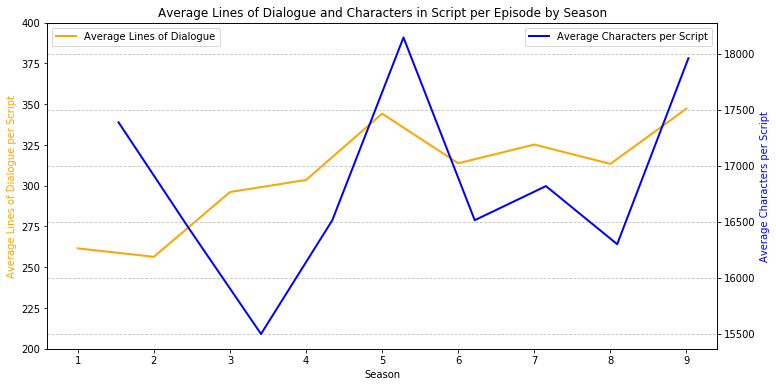

In [26]:
def plot_lines(df_lines_per_season):
    df = df_lines_per_season.copy()
    
    fig = plt.figure(figsize=(12,6))
    
    x = df['Season'].values
    y = df['Average_Lines']
    x_alt = df['Season'].values
    y_alt = df['Average_Chars']
        
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()

    
    ax1.plot(x, y, lw=2, label='Average Lines of Dialogue', color='orange')
    width = 0.7
    ax1.legend(loc='upper left')
    
    ax2.plot(x_alt, y_alt, lw=2, label='Average Characters per Script', color='b')
    width = 0.24

    
    plt.ylabel('% of Episodes Written')
    plt.xticks(range(10))
    plt.xlabel('Season')
    plt.legend()
    plt.title('Average Lines of Dialogue and Characters in Script per Episode by Season', loc='center')
    ax1.set_xlabel('Season')
    ax1.set_ylabel('Average Lines of Dialogue per Script', color='orange')
    ax2.set_ylabel('Average Characters per Script', color='b')
    
    plt.grid(linestyle="--", color=(0.75, 0.75, 0.75, 0.1))
    
    ax1.set_ylim(200, 400)
    plt.show()
    

plot_lines(df_lines_per_season)

In [27]:
df_lines_per_season.Total_Chars.sum()

2920645

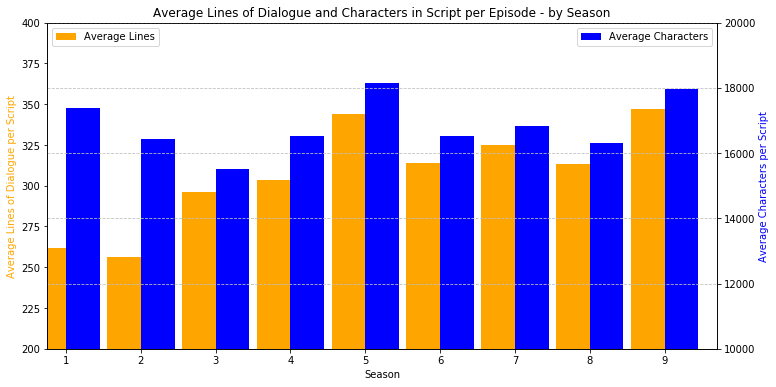

In [28]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.45

df_lines_per_season.Average_Lines.plot(kind='bar', color='orange', ax=ax, width=width, position=1, label="Average Lines")
df_lines_per_season.Average_Chars.plot(kind='bar', color='blue', ax=ax2, width=width, position=0, label="Average Characters")

plt.title('Average Lines of Dialogue and Characters in Script per Episode - by Season', loc='center')

ax.set_ylabel('Average Lines of Dialogue per Script', color='orange')
ax2.set_ylabel('Average Characters per Script', color='b')

ax.legend(loc='upper left')
ax.set_ylim(200, 400)
ax2.legend(loc='upper right')
plt.xlabel('Season')
ax.set_xlabel('Season')
ax2.set_ylim(10000, 20000)
ax.set_xticklabels(range(1,10),rotation=0)

plt.grid(linestyle="--", color=(0.75, 0.75, 0.75, 0.1))

plt.show()

In [448]:
df_scripts.head()

,Character,Dialogue,EpisodeNo,SEID,Season
0,JERRY,Do you know what this is all about? Do you kno...,0.0,S01E00,1.0
1,JERRY,"(pointing at Georges shirt) See, to me, that b...",0.0,S01E00,1.0
2,GEORGE,Are you through?,0.0,S01E00,1.0
3,JERRY,"You do of course try on, when you buy?",0.0,S01E00,1.0
4,GEORGE,"Yes, it was purple, I liked it, I dont actuall...",0.0,S01E00,1.0


In [449]:
# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyzer.polarity_scores(sentence)
    print("{:-<40} {}".format(sentence, str(score)))
    
sentiment_analyzer_scores(df_scripts.Dialogue[0])

Do you know what this is all about? Do you know, why were here? To be out, this is out...and out is one of the single most enjoyable experiences of life. People...did you ever hear people talking about We should go out? This is what theyre talking about...this whole thing, were all out now, no one is home. Not one person here is home, were all out! There are people tryin to find us, they dont know where we are. (on an imaginary phone) Did you ring?, I cant find him. Where did he go? He didnt tell me where he was going. He must have gone out. You wanna go out you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...Then youre standing around, whatta you do? You go We gotta be getting back. Once youre out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, its my feeling, youve gotta go. {'neg': 0.011, 'neu': 0.9

In [464]:
test_sent = "Not one person here is home, were all out! OUT! BOO HOO Excellent"
sentiment_analyzer_scores(test_sent)

Not one person here is home, were all out! OUT! BOO HOO Excellent {'neg': 0.0, 'neu': 0.737, 'pos': 0.263, 'compound': 0.6467}


In [517]:
test_sent = "I'll talk slower. I'm kidding - I love Cellblock D. My friend George is in Cellblock D. What are you in for,sir?"
sentiment_analyzer_scores(test_sent)

I'll talk slower. I'm kidding - I love Cellblock D. My friend George is in Cellblock D. What are you in for,sir? {'neg': 0.0, 'neu': 0.659, 'pos': 0.341, 'compound': 0.8316}


In [485]:
test_paragpaph = df_scripts.Dialogue[0]
test_paragpaph

'Do you know what this is all about? Do you know, why were here? To be out, this is out...and out is one of the single most enjoyable experiences of life. People...did you ever hear people talking about We should go out? This is what theyre talking about...this whole thing, were all out now, no one is home. Not one person here is home, were all out! There are people tryin to find us, they dont know where we are. (on an imaginary phone) Did you ring?, I cant find him. Where did he go? He didnt tell me where he was going. He must have gone out. You wanna go out you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...Then youre standing around, whatta you do? You go We gotta be getting back. Once youre out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, its my feeling, youve gotta go.'

In [488]:
test_paragraph_new = test_paragpaph.replace('?','~').replace('...',' ').replace('!','~').replace('.','~').split('~') #.split('.').split('!')
test_paragraph_new

['Do you know what this is all about',
 ' Do you know, why were here',
 ' To be out, this is out and out is one of the single most enjoyable experiences of life',
 ' People did you ever hear people talking about We should go out',
 ' This is what theyre talking about this whole thing, were all out now, no one is home',
 ' Not one person here is home, were all out',
 ' There are people tryin to find us, they dont know where we are',
 ' (on an imaginary phone) Did you ring',
 ', I cant find him',
 ' Where did he go',
 ' He didnt tell me where he was going',
 ' He must have gone out',
 ' You wanna go out you get ready, you pick out the clothes, right',
 ' You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation Then youre standing around, whatta you do',
 ' You go We gotta be getting back',
 ' Once youre out, you wanna get back',
 ' You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right',
 ' Where ever you are in l

In [493]:
for sent in test_paragraph_new:
    x = sentiment_analyzer_scores(sent)
    print(x)
    

Do you know what this is all about------ {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
None
 Do you know, why were here------------- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
None
 To be out, this is out and out is one of the single most enjoyable experiences of life {'neg': 0.0, 'neu': 0.842, 'pos': 0.158, 'compound': 0.4927}
None
 People did you ever hear people talking about We should go out {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
None
 This is what theyre talking about this whole thing, were all out now, no one is home {'neg': 0.121, 'neu': 0.879, 'pos': 0.0, 'compound': -0.296}
None
 Not one person here is home, were all out {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
None
 There are people tryin to find us, they dont know where we are {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
None
 (on an imaginary phone) Did you ring--- {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
None
, I cant find him----------------------- {'neg

In [526]:
def sentiment_analyzer(df_scripts):
    df = df_scripts.copy().reset_index(drop=True)
    
    sentiments = []
    
    # Sentiment Analysis using VADER
    analyzer = SentimentIntensityAnalyzer()

    for i in range(df.shape[0]):
        # feed in one line at a time to the sentiment analyzer
        line = df['Dialogue'].iloc[i]
        sentiment = analyzer.polarity_scores(line)
        
        # append to list of sentiments
        sentiments.append([sentiment['neg'], sentiment['pos'],
                           sentiment['neu'], sentiment['compound']])
        
    # create new columns for sentiments
    df[['neg', 'pos', 'neu', 'compound']] = pd.DataFrame(sentiments)
    
    # don't want 0's to be counted as positive or negative, since many neutral statments
    df['Negative'] = df['compound'] < -0.1
    df['Positive'] = df['compound'] > 0.1
    return df

df_sentiment = sentiment_analyzer(df_scripts)

In [527]:
pd.options.display.max_colwidth = 1000
df_sentiment.head(20)

,Character,Dialogue,EpisodeNo,SEID,Season,neg,pos,neu,compound,Negative,Positive
0,JERRY,"Do you know what this is all about? Do you know, why were here? To be out, this is out...and out is one of the single most enjoyable experiences of life. People...did you ever hear people talking about We should go out? This is what theyre talking about...this whole thing, were all out now, no one is home. Not one person here is home, were all out! There are people tryin to find us, they dont know where we are. (on an imaginary phone) Did you ring?, I cant find him. Where did he go? He didnt tell me where he was going. He must have gone out. You wanna go out you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...Then youre standing around, whatta you do? You go We gotta be getting back. Once youre out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, its my feeling, youve gotta go.",0.0,S01E00,1.0,0.011,0.072,0.917,0.9029,False,True
1,JERRY,"(pointing at Georges shirt) See, to me, that button is in the worst possible spot. The second button literally makes or breaks the shirt, look at it. Its too high! Its in no-mans-land. You look like you live with your mother.",0.0,S01E00,1.0,0.096,0.054,0.850,-0.4389,True,False
2,GEORGE,Are you through?,0.0,S01E00,1.0,0.000,0.000,1.000,0.0000,False,False
3,JERRY,"You do of course try on, when you buy?",0.0,S01E00,1.0,0.000,0.000,1.000,0.0000,False,False
4,GEORGE,"Yes, it was purple, I liked it, I dont actually recall considering the buttons.",0.0,S01E00,1.0,0.000,0.355,0.645,0.6705,False,True
5,JERRY,"Oh, you dont recall?",0.0,S01E00,1.0,0.000,0.000,1.000,0.0000,False,False
6,GEORGE,"(on an imaginary microphone) Uh, no, not at this time.",0.0,S01E00,1.0,0.196,0.000,0.804,-0.2960,True,False
7,JERRY,"Well, senator, Id just like to know, what you knew and when you knew it.",0.0,S01E00,1.0,0.000,0.261,0.739,0.5574,False,True
8,CLAIRE,Mr. Seinfeld. Mr. Costanza.,0.0,S01E00,1.0,0.000,0.000,1.000,0.0000,False,False
9,GEORGE,"Are, are you sure this is decaf? Wheres the orange indicator?",0.0,S01E00,1.0,0.000,0.210,0.790,0.3939,False,True


In [528]:
df_scripts

,Character,Dialogue,EpisodeNo,SEID,Season
0,JERRY,"Do you know what this is all about? Do you know, why were here? To be out, this is out...and out is one of the single most enjoyable experiences of life. People...did you ever hear people talking about We should go out? This is what theyre talking about...this whole thing, were all out now, no one is home. Not one person here is home, were all out! There are people tryin to find us, they dont know where we are. (on an imaginary phone) Did you ring?, I cant find him. Where did he go? He didnt tell me where he was going. He must have gone out. You wanna go out you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...Then youre standing around, whatta you do? You go We gotta be getting back. Once youre out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, its my feeling, youve gotta go.",0.0,S01E00,1.0
1,JERRY,"(pointing at Georges shirt) See, to me, that button is in the worst possible spot. The second button literally makes or breaks the shirt, look at it. Its too high! Its in no-mans-land. You look like you live with your mother.",0.0,S01E00,1.0
2,GEORGE,Are you through?,0.0,S01E00,1.0
3,JERRY,"You do of course try on, when you buy?",0.0,S01E00,1.0
4,GEORGE,"Yes, it was purple, I liked it, I dont actually recall considering the buttons.",0.0,S01E00,1.0
5,JERRY,"Oh, you dont recall?",0.0,S01E00,1.0
6,GEORGE,"(on an imaginary microphone) Uh, no, not at this time.",0.0,S01E00,1.0
7,JERRY,"Well, senator, Id just like to know, what you knew and when you knew it.",0.0,S01E00,1.0
8,CLAIRE,Mr. Seinfeld. Mr. Costanza.,0.0,S01E00,1.0
9,GEORGE,"Are, are you sure this is decaf? Wheres the orange indicator?",0.0,S01E00,1.0


In [539]:
df_sentiment.tail(20)

,Character,Dialogue,EpisodeNo,SEID,Season,neg,pos,neu,compound,Negative,Positive
54586,JERRY,I think that would be a very nice gesture.,23.0,S09E23,9.0,0.000,0.340,0.660,0.4754,False,True
54587,KRAMER,"I got it - it's out! How about that, huh? Oh, boy, what a relief.",23.0,S09E23,9.0,0.000,0.236,0.764,0.5255,False,True
54588,JERRY,"See now, to me, that button is in the worst possible spot.",23.0,S09E23,9.0,0.272,0.000,0.728,-0.6249,True,False
54589,GEORGE,Really?,23.0,S09E23,9.0,0.000,0.000,1.000,0.0000,False,False
54590,JERRY,"Oh yeah. The second button is the key button. It literally makes or breaks the shirt. Look at it, it's too high, it's in no-man's land.",23.0,S09E23,9.0,0.000,0.081,0.919,0.2960,False,True
54591,GEORGE,Haven't we had this conversation before?,23.0,S09E23,9.0,0.000,0.000,1.000,0.0000,False,False
54592,JERRY,You think?,23.0,S09E23,9.0,0.000,0.000,1.000,0.0000,False,False
54593,GEORGE,I think we have.,23.0,S09E23,9.0,0.000,0.000,1.000,0.0000,False,False
54594,JERRY,"Yeah, maybe we have.",23.0,S09E23,9.0,0.000,0.423,0.577,0.2960,False,True
54595,JERRY,"So what is the deal with the yard? I mean when I was a kid my mother wanted me to play in the yard. But of course she didn't have to worry about my next door neighbor Tommy sticking a shiv in my thigh. And what's with the lockdown? Why do we have to be locked in our cells? Are we that bad that we have to be sent to prison, in prison? You would think the weightlifting and the sodomy is enough. So, anyone from Cellblock D?",23.0,S09E23,9.0,0.148,0.049,0.803,-0.9153,True,False


In [531]:
df_sentiment[df_sentiment.isnull().any(axis=1)]

,Character,Dialogue,EpisodeNo,SEID,Season,neg,pos,neu,compound,Negative,Positive


In [550]:
# calculate statistics for sentiment - Entire Season
positives_series = df_sentiment['Positive'].sum()
negatives_series = df_sentiment['Negative'].sum()
total_series = df_sentiment.shape[0]
print(f"Positive lines for entire series: {positives_series / total_series * 100:.0f}%")
print(f"Negative lines for entire series: {negatives_series / total_series * 100:.0f}%")
print(f"Neutral lines for entire series: {(total_series - positives_series - negatives_series) / total_series * 100:.0f}%")

Positive lines for entire series: 31%
Negative lines for entire series: 16%
Neutral lines for entire series: 53%


In [610]:
def sentiment_by_episode(df_sentiment, df_info):
    df = df_sentiment.copy()

    df_lines_per_season = df.groupby(['SEID'], as_index=False)['Dialogue'].count()
    
    df_sum_negative_lines = df.groupby(['SEID'],as_index=False)['Negative'].sum()
    df_sum_positive_lines = df.groupby(['SEID'],as_index=False)['Positive'].sum() 


    df_merged = df_lines_per_season.merge(df_sum_negative_lines)
    df_merged = df_merged.merge(df_sum_positive_lines)
    
    print(df_merged.head(5))
    
    df_merged['Percent_Negative'] = df_merged['Negative'] / df_merged['Dialogue']
    df_merged['Percent_Positive'] = df_merged['Positive'] / df_merged['Dialogue']

    
    df_merged = df_merged.merge(df_info)
    
    return df_merged

df_sentiment_by_episode = sentiment_by_episode(df_sentiment, df_info)
df_sentiment_by_episode.head(20)

     SEID  Dialogue  Negative  Positive
0  S01E00       211      31.0      88.0
1  S01E01       346      62.0     105.0
2  S01E02       280      52.0      90.0
3  S01E03       241      47.0      74.0
4  S01E04       230      41.0      64.0


,SEID,Dialogue,Negative,Positive,Percent_Negative,Percent_Positive,Season,EpisodeNo,Title,AirDate,Writers,Director,Rating
0,S01E00,211,31.0,88.0,0.146919,0.417062,1,0,"Good News, Bad News",5-Jul-89,"Larry David, Jerry Seinfeld",Art Wolff,NaN
1,S01E01,346,62.0,105.0,0.179191,0.303468,1,1,The Stakeout,31-May-90,"Larry David, Jerry Seinfeld",Tom Cherones,NaN
2,S01E02,280,52.0,90.0,0.185714,0.321429,1,2,The Robbery,7-Jun-90,Matt Goldman,Tom Cherones,NaN
3,S01E03,241,47.0,74.0,0.195021,0.307054,1,3,Male Unbonding,14-Jun-90,"Larry David, Jerry Seinfeld",Tom Cherones,NaN
4,S01E04,230,41.0,64.0,0.178261,0.278261,1,4,The Stock Tip,21-Jun-90,"Larry David, Jerry Seinfeld",Tom Cherones,NaN
5,S02E01,245,61.0,78.0,0.248980,0.318367,2,1,The Ex-Girlfriend,16-Jan-91,"Larry David, Jerry Seinfeld",Tom Cherones,NaN
6,S02E02,250,60.0,70.0,0.240000,0.280000,2,2,The Pony Remark,30-Jan-91,"Larry David, Jerry Seinfeld",Tom Cherones,NaN
7,S02E03,261,60.0,75.0,0.229885,0.287356,2,3,The Jacket,6-Feb-91,"Larry David, Jerry Seinfeld",Tom Cherones,NaN
8,S02E04,264,50.0,101.0,0.189394,0.382576,2,4,The Phone Message,13-Feb-91,"Larry David, Jerry Seinfeld",Tom Cherones,NaN
9,S02E05,281,57.0,87.0,0.202847,0.309609,2,5,The Apartment,4-Apr-91,Peter Mehlman,Tom Cherones,NaN


In [611]:
# Most Negative Episodes of Seinfeld
df_sentiment_by_episode.nlargest(5, 'Percent_Negative')

,SEID,Dialogue,Negative,Positive,Percent_Negative,Percent_Positive,Season,EpisodeNo,Title,AirDate,Writers,Director,Rating
5,S02E01,245,61.0,78.0,0.248980,0.318367,2,1,The Ex-Girlfriend,16-Jan-91,"Larry David, Jerry Seinfeld",Tom Cherones,NaN
6,S02E02,250,60.0,70.0,0.240000,0.280000,2,2,The Pony Remark,30-Jan-91,"Larry David, Jerry Seinfeld",Tom Cherones,NaN
134,S08E04,324,76.0,93.0,0.234568,0.287037,8,4,The Little Kicks,10-Oct-96,Spike Feresten,Andy Ackerman,NaN
14,S02E10,233,54.0,57.0,0.231760,0.244635,2,10,The Baby Shower,16-May-91,Larry Charles,Tom Cherones,NaN
7,S02E03,261,60.0,75.0,0.229885,0.287356,2,3,The Jacket,6-Feb-91,"Larry David, Jerry Seinfeld",Tom Cherones,NaN


In [659]:
def pandas_df_to_markdown_table(df):
    from IPython.display import Markdown, display
    fmt = ['---' for i in range(len(df.columns))]
    df_fmt = pd.DataFrame([fmt], columns=df.columns)
    df_formatted = pd.concat([df_fmt, df])
    display(Markdown(df_formatted.to_csv(sep="|", index=False)))
    
pandas_df_to_markdown_table(df_sentiment_by_episode)

SEID|Dialogue|Negative|Positive|Percent_Negative|Percent_Positive|Season|EpisodeNo|Title|AirDate|Writers|Director|Rating
---|---|---|---|---|---|---|---|---|---|---|---|---
S01E00|211|31.0|88.0|0.14691943127962084|0.41706161137440756|1|0|Good News, Bad News|5-Jul-89|Larry David, Jerry Seinfeld|Art Wolff|
S01E01|346|62.0|105.0|0.1791907514450867|0.30346820809248554|1|1|The Stakeout|31-May-90|Larry David, Jerry Seinfeld|Tom Cherones|
S01E02|280|52.0|90.0|0.18571428571428572|0.32142857142857145|1|2|The Robbery|7-Jun-90|Matt Goldman|Tom Cherones|
S01E03|241|47.0|74.0|0.1950207468879668|0.3070539419087137|1|3|Male Unbonding|14-Jun-90|Larry David, Jerry Seinfeld|Tom Cherones|
S01E04|230|41.0|64.0|0.1782608695652174|0.2782608695652174|1|4|The Stock Tip|21-Jun-90|Larry David, Jerry Seinfeld|Tom Cherones|
S02E01|245|61.0|78.0|0.24897959183673468|0.3183673469387755|2|1|The Ex-Girlfriend|16-Jan-91|Larry David, Jerry Seinfeld|Tom Cherones|
S02E02|250|60.0|70.0|0.24|0.28|2|2|The Pony Remark|30-Jan-91|Larry David, Jerry Seinfeld|Tom Cherones|
S02E03|261|60.0|75.0|0.22988505747126436|0.28735632183908044|2|3|The Jacket|6-Feb-91|Larry David, Jerry Seinfeld|Tom Cherones|
S02E04|264|50.0|101.0|0.1893939393939394|0.38257575757575757|2|4|The Phone Message|13-Feb-91|Larry David, Jerry Seinfeld|Tom Cherones|
S02E05|281|57.0|87.0|0.20284697508896798|0.3096085409252669|2|5|The Apartment|4-Apr-91|Peter Mehlman|Tom Cherones|
S02E06|292|57.0|86.0|0.1952054794520548|0.2945205479452055|2|6|The Statue|11-Apr-91|Larry David|Tom Cherones|
S02E07|271|47.0|88.0|0.17343173431734318|0.3247232472324723|2|7|The Revenge|18-Apr-91|Larry David|Tom Cherones|
S02E08|224|36.0|80.0|0.16071428571428573|0.35714285714285715|2|8|The Heart Attack|25-Apr-91|Larry Charles|Tom Cherones|
S02E09|294|46.0|97.0|0.1564625850340136|0.3299319727891156|2|9|The Deal|2-May-91|Larry Charles|Tom Cherones|
S02E10|233|54.0|57.0|0.2317596566523605|0.2446351931330472|2|10|The Baby Shower|16-May-91|Larry Charles|Tom Cherones|
S02E11|239|36.0|65.0|0.1506276150627615|0.2719665271966527|2|11|The Chinese Restaurant|23-May-91|Larry David, Jerry Seinfeld|Tom Cherones|
S02E12|223|41.0|47.0|0.18385650224215247|0.21076233183856502|2|12|The Busboy|26-Jun-91|Larry David, Jerry Seinfeld|Tom Cherones|
S03E01|335|49.0|93.0|0.14626865671641792|0.27761194029850744|3|1|The Note|18-Sep-91|Larry David|Tom Cherones|
S03E02|261|48.0|84.0|0.1839080459770115|0.3218390804597701|3|2|The Truth|25-Sep-91|Elaine Pope|David Steinberg|
S03E03|391|61.0|98.0|0.15601023017902813|0.2506393861892583|3|3|The Pen|2-Oct-91|Larry David|Tom Cherones|
S03E04|261|50.0|74.0|0.19157088122605365|0.2835249042145594|3|4|The Dog|9-Oct-91|Larry David|Tom Cherones|
S03E05|226|47.0|64.0|0.2079646017699115|0.2831858407079646|3|5|The Library|16-Oct-91|Larry Charles|Joshua White|
S03E06|281|51.0|59.0|0.18149466192170818|0.2099644128113879|3|6|The Parking Garage|30-Oct-91|Larry David|Tom Cherones|
S03E07|343|39.0|93.0|0.11370262390670553|0.27113702623906705|3|7|The Cafe|6-Nov-91|Tom Leopold|Tom Cherones|
S03E08|316|34.0|80.0|0.10759493670886076|0.25316455696202533|3|8|The Tape|13-Nov-91|Larry David and Bob Shaw, Don McEnery|David&nbsp; Steinberg|
S03E09|264|41.0|103.0|0.1553030303030303|0.39015151515151514|3|9|The Nose Job|20-Nov-91|Peter Mehlman|Tom Cherones|
S03E10|331|45.0|99.0|0.13595166163141995|0.2990936555891239|3|10|The Stranded|27-Nov-91|Larry David, Jerry Seinfeld and Matt Goldman|Tom Cherones|
S03E11|317|52.0|90.0|0.1640378548895899|0.28391167192429023|3|11|The Alternate Side|4-Dec-91|Larry David and Bill Masters|Tom Cherones|
S03E12|282|40.0|87.0|0.14184397163120568|0.30851063829787234|3|12|The Red Dot|11-Dec-91|Larry David|Tom Cherones|
S03E13|180|39.0|57.0|0.21666666666666667|0.31666666666666665|3|13|The Subway|8-Jan-92|Larry David|Tom Cherones|
S03E14|288|53.0|94.0|0.1840277777777778|0.3263888888888889|3|14|The Pez Dispenser|15-Jan-92|Larry David|Tom Cherones|
S03E15|331|56.0|83.0|0.1691842900302115|0.25075528700906347|3|15|The Suicide|29-Jan-92|Tom Leopold|Tom Cherones|
S03E16|300|60.0|107.0|0.2|0.3566666666666667|3|16|The Fix-Up|5-Feb-92|Elaine Pope, Larry Charles|Tom Cherones|
S03E17|301|39.0|78.0|0.12956810631229235|0.2591362126245847|3|17|The Boyfriend (1)|12-Feb-92|Larry David and Larry Levin|Tom Cherones|
S03E18|229|33.0|88.0|0.14410480349344978|0.38427947598253276|3|18|The Boyfriend (2)|12-Feb-92|Larry David and Larry Levin|Tom Cherones|
S03E19|271|43.0|77.0|0.15867158671586715|0.28413284132841327|3|19|The Limo|26-Feb-92|Larry Charles / Story By Marc Jaffe|Tom Cherones|
S03E20|308|52.0|102.0|0.16883116883116883|0.33116883116883117|3|20|The Good Samaritan|4-Mar-92|Peter Mehlman|Jason Alexander|
S03E21|303|36.0|116.0|0.1188118811881188|0.38283828382838286|3|21|The Letter|25-Mar-92|Larry David|Tom Cherones|
S03E22|397|71.0|124.0|0.17884130982367757|0.3123425692695214|3|22|The Parking Space|22-Apr-92|Larry David and Greg Daniels|Tom Cherones|
S03E23|295|54.0|71.0|0.18305084745762712|0.24067796610169492|3|23|The Keys|6-May-92|Larry Charles|Tom Cherones|
S04E01|289|36.0|122.0|0.1245674740484429|0.42214532871972316|4|1|The Trip (1)|12-Aug-92|Larry Charles|Tom Cherones|
S04E02|266|53.0|73.0|0.19924812030075187|0.2744360902255639|4|2|The Trip (2)|19-Aug-92|Larry Charles|Tom Cherones|
S04E03|360|51.0|105.0|0.14166666666666666|0.2916666666666667|4|3|The Pitch|16-Sep-92|Larry Charles|Tom Cherones|
S04E04|351|55.0|111.0|0.15669515669515668|0.3162393162393162|4|4|The Ticket|16-Sep-92|Larry David|Tom Cherones|
S04E05|362|54.0|117.0|0.14917127071823205|0.32320441988950277|4|5|The Wallet (1)|23-Sep-92|Larry David|Tom Cherones|
S04E06|345|51.0|128.0|0.14782608695652175|0.3710144927536232|4|6|The Watch (2)|30-Sep-92|Larry David|Tom Cherones|
S04E07|362|69.0|118.0|0.19060773480662985|0.3259668508287293|4|7|The Bubble Boy|7-Oct-92|Larry David, Larry Charles|Tom Cherones|
S04E08|338|51.0|122.0|0.15088757396449703|0.3609467455621302|4|8|The Cheever Letters|28-Oct-92|Larry David, Larry Charles|Tom Cherones|
S04E09|299|51.0|92.0|0.1705685618729097|0.3076923076923077|4|9|The Opera|4-Nov-92|Larry Charles|Tom Cherones|
S04E10|316|61.0|94.0|0.1930379746835443|0.2974683544303797|4|10|The Virgin|11-Nov-92|Peter Mehlman|Tom Cherones|
S04E11|339|37.0|95.0|0.10914454277286136|0.28023598820059|4|11|The Contest|18-Nov-92|Larry David|Tom Cherones|
S04E12|244|34.0|74.0|0.13934426229508196|0.30327868852459017|4|12|The Airport|25-Nov-92|Larry Charles|Tom Cherones|
S04E13|288|44.0|86.0|0.1527777777777778|0.2986111111111111|4|13|The Pick|16-Dec-92|Larry Charles|Tom Cherones|
S04E14|234|42.0|61.0|0.1794871794871795|0.2606837606837607|4|14|The Movie|6-Jan-93|Steve Skrovan, Bill Masters, Jon Hayman|Tom Cherones|
S04E15|299|50.0|122.0|0.16722408026755853|0.4080267558528428|4|15|The Visa|27-Jan-93|Peter Mehlman|Tom Cherones|
S04E16|304|49.0|109.0|0.1611842105263158|0.35855263157894735|4|16|The Shoes|4-Feb-93|Larry David, Jerry Seinfeld|Tom Cherones|
S04E17|204|41.0|54.0|0.20098039215686275|0.2647058823529412|4|17|The Outing|11-Feb-93|Larry Charles|Tom Cherones|
S04E18|247|42.0|67.0|0.1700404858299595|0.27125506072874495|4|18|The Old Man|18-Feb-93|Bruce Kirschbaum|Tom Cherones|
S04E19|275|55.0|91.0|0.2|0.33090909090909093|4|19|The Implant|25-Feb-93|Peter Mehlman|Tom Cherones|
S04E20|378|45.0|121.0|0.11904761904761904|0.3201058201058201|4|20|The Junior Mint|18-Mar-93|Andy Robin|Tom Cherones|
S04E21|238|38.0|63.0|0.15966386554621848|0.2647058823529412|4|21|The Smelly Car|15-Apr-93|Larry David, Peter Mehlman|Tom Cherones|
S04E22|325|56.0|123.0|0.1723076923076923|0.37846153846153846|4|22|The Handicap Spot|13-May-93|Larry David|Tom Cherones|
S04E23|347|41.0|110.0|0.11815561959654179|0.3170028818443804|4|23|The Pilot (1)|20-May-93|Larry David|Tom Cherones|
S04E24|275|60.0|77.0|0.21818181818181817|0.28|4|24|The Pilot (2)|20-May-93|Larry David|Tom Cherones|
S05E01|364|57.0|94.0|0.1565934065934066|0.25824175824175827|5|1|The Mango|16-Sep-93|Lawrence H. Levy, Buck Dancer (Larry David pseudonym)|Tom Cherones|
S05E02|297|32.0|106.0|0.10774410774410774|0.3569023569023569|5|2|The Puffy Shirt|23-Sep-93|Larry David|Tom Cherones|
S05E03|324|57.0|96.0|0.17592592592592593|0.2962962962962963|5|3|The Glasses|30-Sep-93|Tom Gammill, Max Pross|Tom Cherones|
S05E04|347|39.0|97.0|0.11239193083573487|0.27953890489913547|5|4|The Sniffing Accountant|7-Oct-93|Larry David, Jerry Seinfeld|Tom Cherones|
S05E05|268|44.0|76.0|0.16417910447761194|0.2835820895522388|5|5|The Bris|14-Oct-93|Larry Charles|Tom Cherones|
S05E06|297|34.0|110.0|0.11447811447811448|0.37037037037037035|5|6|The Lip Reader|28-Oct-93|Carol Leifer|Tom Cherones|
S05E07|340|41.0|121.0|0.12058823529411765|0.3558823529411765|5|7|The Non-Fat Yogurt|4-Nov-93|Larry David|Tom Cherones|
S05E08|291|35.0|99.0|0.12027491408934708|0.3402061855670103|5|8|The Barber|11-Nov-93|Andy Robin|Tom Cherones|
S05E09|370|68.0|117.0|0.1837837837837838|0.3162162162162162|5|9|The Masseuse|18-Nov-93|Peter Mehlman|Tom Cherones|
S05E10|339|36.0|112.0|0.10619469026548672|0.3303834808259587|5|10|The Cigar Store Indian|9-Dec-93|Tom Gammill, Max Pross|Tom Cherones|
S05E11|302|48.0|86.0|0.15894039735099338|0.2847682119205298|5|11|The Conversion|16-Dec-93|Bruce Kirschbaum|Tom Cherones|
S05E12|357|57.0|106.0|0.15966386554621848|0.2969187675070028|5|12|The Stall|6-Jan-94|Larry Charles|Tom Cherones|
S05E13|347|56.0|96.0|0.16138328530259366|0.276657060518732|5|13|The Dinner Party|3-Feb-94|Larry David|Tom Cherones|
S05E14|351|35.0|139.0|0.09971509971509972|0.396011396011396|5|14|The Marine Biologist|10-Feb-94|Ron Hague, Charlie Rubin|Tom Cherones|
S05E15|304|58.0|97.0|0.19078947368421054|0.3190789473684211|5|15|The Pie|17-Feb-94|Tom Gammill, Max Pross|Tom Cherones|
S05E16|346|48.0|92.0|0.13872832369942195|0.2658959537572254|5|16|The Stand-In|24-Feb-94|Larry David|Tom Cherones|
S05E17|347|44.0|124.0|0.12680115273775217|0.3573487031700288|5|17|The Wife|17-Mar-94|Peter Mehlman|Tom Cherones|
S05E18|730|85.0|204.0|0.11643835616438356|0.27945205479452057|5|18|The Raincoats|April 28 1994|Tom Gammill, Max Pross and Larry David, Jerry Seinfeld|Tom Cherones|
S05E20|294|44.0|122.0|0.14965986394557823|0.41496598639455784|5|20|The Fire|5-May-94|Larry Charles|Tom Cherones|
S05E21|314|49.0|107.0|0.15605095541401273|0.34076433121019106|5|21|The Hamptons|12-May-94|Peter Mehlman, Carol Leifer|Tom Cherones|
S05E22|299|32.0|105.0|0.10702341137123746|0.3511705685618729|5|22|The Opposite|19-May-94|Andy Cowan and Larry David, Jerry Seinfeld|Tom Cherones|
S06E01|296|62.0|97.0|0.20945945945945946|0.3277027027027027|6|1|The Chaperone|22-Sep-94|Larry David, Bill Masters, Bob Shaw|Andy Ackerman|
S06E02|291|45.0|99.0|0.15463917525773196|0.3402061855670103|6|2|The Big Salad|29-Sep-94|Larry David|Andy Ackerman|
S06E03|322|45.0|101.0|0.13975155279503104|0.3136645962732919|6|3|The Pledge Drive|6-Oct-94|Tom Gammill, Max Pross|Andy Ackerman|
S06E04|318|58.0|72.0|0.18238993710691823|0.22641509433962265|6|4|The Chinese Woman|13-Oct-94|Peter Mehlman|Andy Ackerman|
S06E05|331|47.0|113.0|0.1419939577039275|0.3413897280966767|6|5|The Couch|27-Oct-94|Larry David|Andy Ackerman|
S06E06|283|55.0|93.0|0.19434628975265017|0.3286219081272085|6|6|The Gymnast|3-Nov-94|Alec Berg, Jeff Schaffer|Andy Ackerman|
S06E07|391|54.0|136.0|0.13810741687979539|0.34782608695652173|6|7|The Soup|10-Nov-94|Fred Stoller|Andy Ackerman|
S06E08|293|43.0|86.0|0.14675767918088736|0.2935153583617747|6|8|The Mom &amp; Pop Store|17-Nov-94|Tom Gammill, Max Pross|Andy Ackerman|
S06E09|325|32.0|132.0|0.09846153846153846|0.40615384615384614|6|9|The Secretary|8-Dec-94|Carol Leifer, Marjorie Gross|David Owen Trainor|
S06E10|295|38.0|111.0|0.1288135593220339|0.376271186440678|6|10|The Race|15-Dec-94|Tom Gammill, Max Pross and Larry David|Andy Ackerman|
S06E11|314|41.0|90.0|0.1305732484076433|0.28662420382165604|6|11|The Switch|5-Jan-95|Bruce Kirschbaum and Sam Kass|Andy Ackerman|
S06E12|333|42.0|135.0|0.12612612612612611|0.40540540540540543|6|12|The Label Maker|19-Jan-95|Alec Berg, Jeff Schaffer|Andy Ackerman|
S06E13|350|52.0|116.0|0.14857142857142858|0.3314285714285714|6|13|The Scofflaw|26-Jan-95|Peter Mehlman|Andy Ackerman|
S06E16|297|48.0|113.0|0.16161616161616163|0.38047138047138046|6|16|The Beard|9-Feb-95|Carol Leifer|Andy Ackerman|
S06E17|381|44.0|138.0|0.11548556430446194|0.36220472440944884|6|17|The Kiss Hello|16-Feb-95|Larry David, Jerry Seinfeld|Andy Ackerman|
S06E18|331|44.0|109.0|0.13293051359516617|0.3293051359516616|6|18|The Doorman|23-Feb-95|Tom Gammill, Max Pross|Andy Ackerman|
S06E19|303|37.0|80.0|0.12211221122112212|0.264026402640264|6|19|The Jimmy|16-Mar-95|Gregg Kavet, Andy Robin|Andy Ackerman|
S06E20|321|49.0|102.0|0.1526479750778816|0.3177570093457944|6|20|The Doodle|6-Apr-95|Alec Berg, Jeff Schaffer|Andy Ackerman|
S06E21|331|50.0|107.0|0.1510574018126888|0.32326283987915405|6|21|The Fusilli Jerry|27-Apr-95|Marjorie Gross|Andy Ackerman|
S06E22|259|47.0|73.0|0.18146718146718147|0.28185328185328185|6|22|The Diplomat's Club|4-May-95|Tom Gammill, Max Pross|Andy Ackerman|
S06E23|299|61.0|116.0|0.2040133779264214|0.3879598662207358|6|23|The Face Painter|11-May-95|Larry David|Andy Ackerman|
S06E24|239|36.0|75.0|0.1506276150627615|0.3138075313807531|6|24|The Understudy|18-May-95|Marjorie Gross, Carol Leifer|Andy Ackerman|
S07E01|312|39.0|111.0|0.125|0.3557692307692308|7|1|The Engagement|21-Sep-95|Larry David|Andy Ackerman|
S07E02|308|56.0|125.0|0.18181818181818182|0.40584415584415584|7|2|The Postponement|28-Sep-95|Larry David|Andy Ackerman|
S07E03|384|49.0|126.0|0.12760416666666666|0.328125|7|3|The Maestro|5-Oct-95|Larry David|Andy Ackerman|
S07E04|340|46.0|107.0|0.13529411764705881|0.31470588235294117|7|4|The Wink|12-Oct-95|Tom Gammill, Max Pross|Andy Ackerman|
S07E05|282|56.0|83.0|0.19858156028368795|0.29432624113475175|7|5|The Hot Tub|19-Oct-95|Gregg Kavet, Andy Robin|Andy Ackerman|
S07E06|393|58.0|142.0|0.1475826972010178|0.361323155216285|7|6|The Soup Nazi|2-Nov-95|Spike Feresten|Andy Ackerman|
S07E07|299|53.0|89.0|0.17725752508361203|0.2976588628762542|7|7|The Secret Code|9-Nov-95|Alec Berg, Jeff Schaffer|Andy Ackerman|
S07E08|354|55.0|110.0|0.1553672316384181|0.3107344632768362|7|8|The Pool Guy|16-Nov-95|David Mandel|Andy Ackerman|
S07E09|325|41.0|93.0|0.12615384615384614|0.28615384615384615|7|9|The Sponge|7-Dec-95|Peter Mehlman|Andy Ackerman|
S07E10|350|49.0|119.0|0.14|0.34|7|10|The Gum|14-Dec-95|Tom Gammill, Max Pross|Andy Ackerman|
S07E11|295|46.0|99.0|0.15593220338983052|0.33559322033898303|7|11|The Rye|4-Jan-96|Carol Leifer|Andy Ackerman|
S07E12|345|55.0|125.0|0.15942028985507245|0.36231884057971014|7|12|The Caddy|25-Jan-96|Gregg Kavet, Andy Robin|Andy Ackerman|
S07E13|345|57.0|136.0|0.16521739130434782|0.39420289855072466|7|13|The Seven|1-Feb-96|Alec Berg, Jeff Schaffer|Andy Ackerman|
S07E14|372|46.0|134.0|0.12365591397849462|0.3602150537634409|7|14|The Cadillac (1)|8-Feb-96|Larry David, Jerry Seinfeld|Andy Ackerman|
S07E15|266|32.0|82.0|0.12030075187969924|0.3082706766917293|7|15|The Cadillac (2)|8-Feb-96|Larry David, Jerry Seinfeld|Andy Ackerman|
S07E16|314|52.0|78.0|0.16560509554140126|0.2484076433121019|7|16|The Shower Head|15-Feb-96|Peter Mehlman, Marjorie Gross|Andy Ackerman|
S07E17|313|43.0|103.0|0.13738019169329074|0.329073482428115|7|17|The Doll|22-Feb-96|Tom Gammill, Max Pross|Andy Ackerman|
S07E18|389|55.0|129.0|0.14138817480719795|0.33161953727506427|7|18|The Friars Club (a.k.a. The Gypsies)|7-Mar-96|David Mandel|Andy Ackerman|
S07E19|355|48.0|105.0|0.1352112676056338|0.29577464788732394|7|19|The Wig Master|4-Apr-96|Spike Feresten|Andy Ackerman|
S07E20|296|49.0|85.0|0.16554054054054054|0.28716216216216217|7|20|The Calzone|25-Apr-96|Alec Berg, Jeff Schaffer|Andy Ackerman|
S07E21|267|33.0|79.0|0.12359550561797752|0.2958801498127341|7|21|The Bottle Deposit (1)|2-May-96|Gregg Kavet, Andy Robin|Andy Ackerman|
S07E22|261|35.0|95.0|0.13409961685823754|0.36398467432950193|7|22|The Bottle Deposit (2)|2-May-96|Gregg Kavet, Andy Robin|Andy Ackerman|
S07E23|309|37.0|96.0|0.11974110032362459|0.3106796116504854|7|23|The Wait Out|9-May-96|Peter Mehlman|Andy Ackerman|
S07E24|332|53.0|100.0|0.15963855421686746|0.30120481927710846|7|24|The Invitations|16-May-96|Larry David|Andy Ackerman|
S08E01|315|52.0|85.0|0.16507936507936508|0.2698412698412698|8|1|The Foundation|19-Sep-96|Alec Berg, Jeff Schaffer|Andy Ackerman|
S08E02|306|42.0|98.0|0.13725490196078433|0.3202614379084967|8|2|The Soul Mate|26-Sep-96|Peter Mehlman|Andy Ackerman|
S08E03|302|40.0|101.0|0.13245033112582782|0.3344370860927152|8|3|The Bizarro Jerry|3-Oct-96|David Mandel|Andy Ackerman|
S08E04|324|76.0|93.0|0.2345679012345679|0.28703703703703703|8|4|The Little Kicks|10-Oct-96|Spike Feresten|Andy Ackerman|
S08E05|325|47.0|98.0|0.14461538461538462|0.30153846153846153|8|5|The Package|17-Oct-96|Jennifer Crittenden|Andy Ackerman|
S08E06|271|59.0|80.0|0.2177121771217712|0.2952029520295203|8|6|The Fatigues|31-Oct-96|Gregg Kavet, Andy Robin|Andy Ackerman|
S08E07|357|39.0|134.0|0.1092436974789916|0.3753501400560224|8|7|The Checks|7-Nov-96|Steve O'Donnell and Tom Gammill, Max Pross|Andy Ackerman|
S08E08|318|58.0|94.0|0.18238993710691823|0.29559748427672955|8|8|The Chicken Roaster|14-Nov-96|Alec Berg, Jeff Schaffer|Andy Ackerman|
S08E09|309|51.0|93.0|0.1650485436893204|0.30097087378640774|8|9|The Abstinence|21-Nov-96|Steve Koren|Andy Ackerman|
S08E10|301|54.0|77.0|0.17940199335548174|0.2558139534883721|8|10|The Andrea Doria|19-Dec-96|Spike Feresten|Andy Ackerman|
S08E11|345|55.0|109.0|0.15942028985507245|0.3159420289855073|8|11|The Little Jerry|9-Jan-97|Jennifer Crittenden|Andy Ackerman|
S08E12|362|44.0|117.0|0.12154696132596685|0.32320441988950277|8|12|The Money|16-Jan-97|Peter Mehlman|Andy Ackerman|
S08E13|286|47.0|95.0|0.16433566433566432|0.3321678321678322|8|13|The Comeback|30-Jan-97|Gregg Kavet, Andy Robin|David Owen Trainor|
S08E14|301|48.0|110.0|0.15946843853820597|0.3654485049833887|8|14|The Van Buren Boys|6-Feb-97|Darin Henry|Andy Ackerman|
S08E15|295|47.0|86.0|0.15932203389830507|0.29152542372881357|8|15|The Susie|13-Feb-97|David Mandel|Andy Ackerman|
S08E16|297|40.0|99.0|0.13468013468013468|0.3333333333333333|8|16|The Pothole|20-Feb-97|Steve O'Donnell and Dan O'Keefe|Andy Ackerman|
S08E17|387|47.0|101.0|0.12144702842377261|0.26098191214470284|8|17|The English Patient|13-Mar-97|Steve Koren|Andy Ackerman|
S08E18|280|48.0|80.0|0.17142857142857143|0.2857142857142857|8|18|The Nap|10-Apr-97|Gregg Kavet, Andy Robin|Andy Ackerman|
S08E19|294|41.0|94.0|0.13945578231292516|0.3197278911564626|8|19|The Yada Yada|24-Apr-97|Peter Mehlman and Jill Franklyn|Andy Ackerman|
S08E20|305|51.0|101.0|0.16721311475409836|0.33114754098360655|8|20|The Millennium|1-May-97|Jennifer Crittenden|Andy Ackerman|
S08E21|287|46.0|93.0|0.1602787456445993|0.3240418118466899|8|21|The Muffin Tops|8-May-97|Spike Feresten|Andy Ackerman|
S08E22|328|56.0|88.0|0.17073170731707318|0.2682926829268293|8|22|The Summer of George|15-May-97|Alec Berg, Jeff Schaffer|Andy Ackerman|
S09E01|312|67.0|94.0|0.21474358974358973|0.30128205128205127|9|1|The Butter Shave|25-Sep-97|Alec Berg, Jeff Schaffer, David Mandel|Andy Ackerman|
S09E02|372|54.0|105.0|0.14516129032258066|0.28225806451612906|9|2|The Voice|2-Oct-97|Alec Berg, Jeff Schaffer, David Mandel|Andy Ackerman|
S09E03|307|52.0|92.0|0.16938110749185667|0.2996742671009772|9|3|The Serenity Now|9-Oct-97|Steve Koren|Andy Ackerman|
S09E04|303|48.0|88.0|0.15841584158415842|0.29042904290429045|9|4|The Blood|16-Oct-97|Dan O'Keefe|Andy Ackerman|
S09E05|321|58.0|109.0|0.1806853582554517|0.3395638629283489|9|5|The Junk Mail|30-Oct-97|Spike Feresten|Andy Ackerman|
S09E06|298|47.0|89.0|0.15771812080536912|0.2986577181208054|9|6|The Merv Griffin Show|6-Nov-97|Bruce Eric Kaplan|Andy Ackerman|
S09E07|344|73.0|101.0|0.21220930232558138|0.2936046511627907|9|7|The Slicer|13-Nov-97|Gregg Kavet, Andy Robin|Andy Ackerman|
S09E08|436|70.0|118.0|0.16055045871559634|0.2706422018348624|9|8|The Betrayal|20-Nov-97|David Mandel, Peter Mehlman|Andy Ackerman|
S09E09|318|61.0|103.0|0.1918238993710692|0.3238993710691824|9|9|The Apology|11-Dec-97|Jennifer Crittenden|Andy Ackerman|
S09E10|365|62.0|112.0|0.16986301369863013|0.30684931506849317|9|10|The Strike|18-Dec-97|Dan O'Keefe, Alec Berg, Jeff Schaffer|Andy Ackerman|
S09E11|352|68.0|98.0|0.19318181818181818|0.2784090909090909|9|11|The Dealership|8-Jan-98|Steve Koren|Andy Ackerman|
S09E12|332|34.0|109.0|0.10240963855421686|0.32831325301204817|9|12|The Reverse Peephole (a.k.a. The Man Fur)|15-Jan-98|Spike Feresten|Andy Ackerman|
S09E13|275|42.0|98.0|0.15272727272727274|0.3563636363636364|9|13|The Cartoon|29-Jan-98|Bruce Eric Kaplan|Andy Ackerman|
S09E14|338|76.0|92.0|0.22485207100591717|0.27218934911242604|9|14|The Strongbox|5-Feb-98|Dan O'Keefe|Andy Ackerman|
S09E15|341|39.0|86.0|0.11436950146627566|0.25219941348973607|9|15|The Wizard|26-Feb-98|Steve Lookner|Andy Ackerman|
S09E16|287|61.0|83.0|0.21254355400696864|0.289198606271777|9|16|The Burning|19-Mar-98|Jennifer Crittenden|Andy Ackerman|
S09E17|301|62.0|91.0|0.2059800664451827|0.3023255813953488|9|17|The Bookstore|9-Apr-98|Spike Feresten|Andy Ackerman|
S09E18|298|46.0|91.0|0.15436241610738255|0.3053691275167785|9|18|The Frogger|23-Apr-98|Gregg Kavet, Andy Robin|Andy Ackerman|
S09E19|364|62.0|82.0|0.17032967032967034|0.22527472527472528|9|19|The Maid|30-Apr-98|Alec Berg, David Mandel, Jeff Schaffer|Andy Ackerman|
S09E20|316|61.0|88.0|0.1930379746835443|0.27848101265822783|9|20|The Puerto Rican Day|7-May-98|Alec Berg, Jennifer Crittenden, Spike Feresten, Bruce Eric Kaplan, Gregg Kavet, Steve Koren, David Mandel, Dan O'Keefe, Andy Robin and Jeff Schaffer.|Andy Ackerman|
S09E23|713|132.0|225.0|0.18513323983169705|0.3155680224403927|9|23|The Finale|14-May-98|Larry David|Andy Ackerman|


In [670]:
cols_for_table = ['Title', 'AirDate', 'Writers', 'Director', 'Percent_Positive', 'Percent_Negative']
print(tabulate(df_sentiment_by_episode.nlargest(5, 'Percent_Negative')[cols_for_table], tablefmt="pipe", headers="keys"))

|     | Title             | AirDate   | Writers                     | Director      |   Percent_Positive |   Percent_Negative |
|----:|:------------------|:----------|:----------------------------|:--------------|-------------------:|-------------------:|
|   5 | The Ex-Girlfriend | 16-Jan-91 | Larry David, Jerry Seinfeld | Tom Cherones  |           0.318367 |           0.24898  |
|   6 | The Pony Remark   | 30-Jan-91 | Larry David, Jerry Seinfeld | Tom Cherones  |           0.28     |           0.24     |
| 134 | The Little Kicks  | 10-Oct-96 | Spike Feresten              | Andy Ackerman |           0.287037 |           0.234568 |
|  14 | The Baby Shower   | 16-May-91 | Larry Charles               | Tom Cherones  |           0.244635 |           0.23176  |
|   7 | The Jacket        | 6-Feb-91  | Larry David, Jerry Seinfeld | Tom Cherones  |           0.287356 |           0.229885 |


In [612]:
# Least Negative Episodes of Seinfeld
df_sentiment_by_episode.nsmallest(5, 'Percent_Negative')

,SEID,Dialogue,Negative,Positive,Percent_Negative,Percent_Positive,Season,EpisodeNo,Title,AirDate,Writers,Director,Rating
93,S06E09,325,32.0,132.0,0.098462,0.406154,6,9,The Secretary,8-Dec-94,"Carol Leifer, Marjorie Gross",David Owen Trainor,NaN
77,S05E14,351,35.0,139.0,0.099715,0.396011,5,14,The Marine Biologist,10-Feb-94,"Ron Hague, Charlie Rubin",Tom Cherones,NaN
164,S09E12,332,34.0,109.0,0.102410,0.328313,9,12,The Reverse Peephole (a.k.a. The Man Fur),15-Jan-98,Spike Feresten,Andy Ackerman,NaN
73,S05E10,339,36.0,112.0,0.106195,0.330383,5,10,The Cigar Store Indian,9-Dec-93,"Tom Gammill, Max Pross",Tom Cherones,NaN
84,S05E22,299,32.0,105.0,0.107023,0.351171,5,22,The Opposite,19-May-94,"Andy Cowan and Larry David, Jerry Seinfeld",Tom Cherones,NaN


In [671]:
cols_for_table = ['Title', 'AirDate', 'Writers', 'Director', 'Percent_Positive', 'Percent_Negative']
print(tabulate(df_sentiment_by_episode.nsmallest(5, 'Percent_Negative')[cols_for_table], tablefmt="pipe", headers="keys"))

|     | Title                                     | AirDate   | Writers                                    | Director           |   Percent_Positive |   Percent_Negative |
|----:|:------------------------------------------|:----------|:-------------------------------------------|:-------------------|-------------------:|-------------------:|
|  93 | The Secretary                             | 8-Dec-94  | Carol Leifer, Marjorie Gross               | David Owen Trainor |           0.406154 |          0.0984615 |
|  77 | The Marine Biologist                      | 10-Feb-94 | Ron Hague, Charlie Rubin                   | Tom Cherones       |           0.396011 |          0.0997151 |
| 164 | The Reverse Peephole (a.k.a. The Man Fur) | 15-Jan-98 | Spike Feresten                             | Andy Ackerman      |           0.328313 |          0.10241   |
|  73 | The Cigar Store Indian                    | 9-Dec-93  | Tom Gammill, Max Pross                     | Tom Cherones       |           

In [613]:
# Most Positive Episodes of Seinfeld
df_sentiment_by_episode.nlargest(5, 'Percent_Positive')

,SEID,Dialogue,Negative,Positive,Percent_Negative,Percent_Positive,Season,EpisodeNo,Title,AirDate,Writers,Director,Rating
40,S04E01,289,36.0,122.0,0.124567,0.422145,4,1,The Trip (1),12-Aug-92,Larry Charles,Tom Cherones,NaN
0,S01E00,211,31.0,88.0,0.146919,0.417062,1,0,"Good News, Bad News",5-Jul-89,"Larry David, Jerry Seinfeld",Art Wolff,NaN
82,S05E20,294,44.0,122.0,0.149660,0.414966,5,20,The Fire,5-May-94,Larry Charles,Tom Cherones,NaN
54,S04E15,299,50.0,122.0,0.167224,0.408027,4,15,The Visa,27-Jan-93,Peter Mehlman,Tom Cherones,NaN
93,S06E09,325,32.0,132.0,0.098462,0.406154,6,9,The Secretary,8-Dec-94,"Carol Leifer, Marjorie Gross",David Owen Trainor,NaN


In [673]:
cols_for_table = ['Title', 'AirDate', 'Writers', 'Director', 'Percent_Positive', 'Percent_Negative']
print(tabulate(df_sentiment_by_episode.nlargest(5, 'Percent_Positive')[cols_for_table], tablefmt="pipe", headers="keys"))

|    | Title               | AirDate   | Writers                      | Director           |   Percent_Positive |   Percent_Negative |
|---:|:--------------------|:----------|:-----------------------------|:-------------------|-------------------:|-------------------:|
| 40 | The Trip (1)        | 12-Aug-92 | Larry Charles                | Tom Cherones       |           0.422145 |          0.124567  |
|  0 | Good News, Bad News | 5-Jul-89  | Larry David, Jerry Seinfeld  | Art Wolff          |           0.417062 |          0.146919  |
| 82 | The Fire            | 5-May-94  | Larry Charles                | Tom Cherones       |           0.414966 |          0.14966   |
| 54 | The Visa            | 27-Jan-93 | Peter Mehlman                | Tom Cherones       |           0.408027 |          0.167224  |
| 93 | The Secretary       | 8-Dec-94  | Carol Leifer, Marjorie Gross | David Owen Trainor |           0.406154 |          0.0984615 |


In [614]:
# Least Positive Episodes of Seinfeld
df_sentiment_by_episode.nsmallest(5, 'Percent_Positive')

,SEID,Dialogue,Negative,Positive,Percent_Negative,Percent_Positive,Season,EpisodeNo,Title,AirDate,Writers,Director,Rating
22,S03E06,281,51.0,59.0,0.181495,0.209964,3,6,The Parking Garage,30-Oct-91,Larry David,Tom Cherones,NaN
16,S02E12,223,41.0,47.0,0.183857,0.210762,2,12,The Busboy,26-Jun-91,"Larry David, Jerry Seinfeld",Tom Cherones,NaN
171,S09E19,364,62.0,82.0,0.170330,0.225275,9,19,The Maid,30-Apr-98,"Alec Berg, David Mandel, Jeff Schaffer",Andy Ackerman,NaN
88,S06E04,318,58.0,72.0,0.182390,0.226415,6,4,The Chinese Woman,13-Oct-94,Peter Mehlman,Andy Ackerman,NaN
39,S03E23,295,54.0,71.0,0.183051,0.240678,3,23,The Keys,6-May-92,Larry Charles,Tom Cherones,NaN


In [674]:
cols_for_table = ['Title', 'AirDate', 'Writers', 'Director', 'Percent_Positive', 'Percent_Negative']
print(tabulate(df_sentiment_by_episode.nsmallest(5, 'Percent_Positive')[cols_for_table], tablefmt="pipe", headers="keys"))

|     | Title              | AirDate   | Writers                                | Director      |   Percent_Positive |   Percent_Negative |
|----:|:-------------------|:----------|:---------------------------------------|:--------------|-------------------:|-------------------:|
|  22 | The Parking Garage | 30-Oct-91 | Larry David                            | Tom Cherones  |           0.209964 |           0.181495 |
|  16 | The Busboy         | 26-Jun-91 | Larry David, Jerry Seinfeld            | Tom Cherones  |           0.210762 |           0.183857 |
| 171 | The Maid           | 30-Apr-98 | Alec Berg, David Mandel, Jeff Schaffer | Andy Ackerman |           0.225275 |           0.17033  |
|  88 | The Chinese Woman  | 13-Oct-94 | Peter Mehlman                          | Andy Ackerman |           0.226415 |           0.18239  |
|  39 | The Keys           | 6-May-92  | Larry Charles                          | Tom Cherones  |           0.240678 |           0.183051 |


In [615]:
def sentiment_by_season(df_sentiment_by_episode):
    df = df_sentiment_by_episode.copy()

    df_lines_per_season = df.groupby(['Season'], as_index=False)['Dialogue'].sum()
    
    df_sum_negative_lines = df.groupby(['Season'],as_index=False)['Negative'].sum()
    df_sum_positive_lines = df.groupby(['Season'],as_index=False)['Positive'].sum() 


    df_merged = df_lines_per_season.merge(df_sum_negative_lines)
    df_merged = df_merged.merge(df_sum_positive_lines)
    
    print(df_merged.head(5))
    
    df_merged['Percent_Negative'] = df_merged['Negative'] / df_merged['Dialogue']
    df_merged['Percent_Positive'] = df_merged['Positive'] / df_merged['Dialogue']
    
    #df_merged = df_merged.merge(df_info)
    
    return df_merged

df_sentiment_by_season = sentiment_by_season(df_sentiment_by_episode)
df_sentiment_by_season.head(20)

   Season  Dialogue  Negative  Positive
0       1      1308     233.0     421.0
1       2      3077     605.0     931.0
2       3      6811    1093.0    2021.0
3       4      7285    1166.0    2335.0
4       5      7228     999.0    2306.0


,Season,Dialogue,Negative,Positive,Percent_Negative,Percent_Positive
0,1,1308,233.0,421.0,0.178135,0.321865
1,2,3077,605.0,931.0,0.196620,0.302567
2,3,6811,1093.0,2021.0,0.160476,0.296726
3,4,7285,1166.0,2335.0,0.160055,0.320522
4,5,7228,999.0,2306.0,0.138213,0.319037
5,6,6903,1030.0,2294.0,0.149210,0.332319
6,7,7806,1143.0,2551.0,0.146426,0.326800
7,8,6895,1088.0,2126.0,0.157796,0.308339
8,9,7293,1275.0,2154.0,0.174825,0.295352


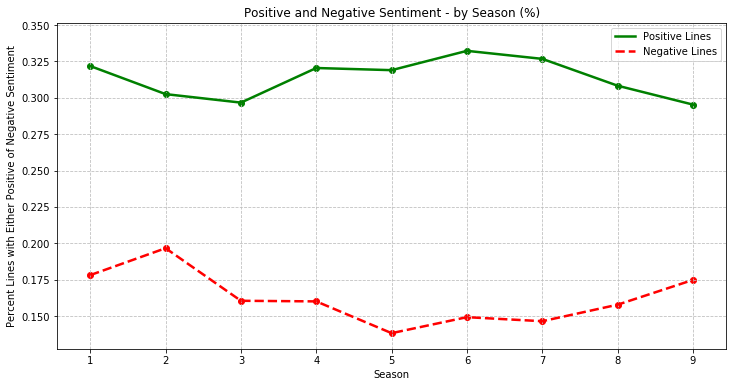

In [658]:
def plot_sentiment_by_season(df_sentiment_by_season):
    df = df_sentiment_by_season.copy()
    
    fig = plt.figure(figsize=(12,6))
    
 
    x = df['Season']
    y_pos = df['Percent_Positive']
    y_neg = df['Percent_Negative']
        
    plt.scatter(x, y_pos, label='_nolegend_', color='g')
    plt.plot(x, y_pos, label='Positive Lines', lw=2.5, color='g')
    
    plt.scatter(x, y_neg, label='_nolegend_', color='r')
    plt.plot(x, y_neg, label='Negative Lines', lw=2.5, color='r', linestyle='--')

    plt.grid(linestyle="--", color=(0.75, 0.75, 0.75, 0.1))
    plt.ylabel('Percent Lines with Either Positive of Negative Sentiment')
    plt.xlabel('Season')
    plt.legend()
    plt.title('Positive and Negative Sentiment - by Season (%)', loc='center')
    plt.show()

plot_sentiment_by_season(df_sentiment_by_season)

In [617]:
df_sentiment

,Character,Dialogue,EpisodeNo,SEID,Season,neg,pos,neu,compound,Negative,Positive
0,JERRY,"Do you know what this is all about? Do you know, why were here? To be out, this is out...and out is one of the single most enjoyable experiences of life. People...did you ever hear people talking about We should go out? This is what theyre talking about...this whole thing, were all out now, no one is home. Not one person here is home, were all out! There are people tryin to find us, they dont know where we are. (on an imaginary phone) Did you ring?, I cant find him. Where did he go? He didnt tell me where he was going. He must have gone out. You wanna go out you get ready, you pick out the clothes, right? You take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...Then youre standing around, whatta you do? You go We gotta be getting back. Once youre out, you wanna get back! You wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? Where ever you are in life, its my feeling, youve gotta go.",0.0,S01E00,1.0,0.011,0.072,0.917,0.9029,False,True
1,JERRY,"(pointing at Georges shirt) See, to me, that button is in the worst possible spot. The second button literally makes or breaks the shirt, look at it. Its too high! Its in no-mans-land. You look like you live with your mother.",0.0,S01E00,1.0,0.096,0.054,0.850,-0.4389,True,False
2,GEORGE,Are you through?,0.0,S01E00,1.0,0.000,0.000,1.000,0.0000,False,False
3,JERRY,"You do of course try on, when you buy?",0.0,S01E00,1.0,0.000,0.000,1.000,0.0000,False,False
4,GEORGE,"Yes, it was purple, I liked it, I dont actually recall considering the buttons.",0.0,S01E00,1.0,0.000,0.355,0.645,0.6705,False,True
5,JERRY,"Oh, you dont recall?",0.0,S01E00,1.0,0.000,0.000,1.000,0.0000,False,False
6,GEORGE,"(on an imaginary microphone) Uh, no, not at this time.",0.0,S01E00,1.0,0.196,0.000,0.804,-0.2960,True,False
7,JERRY,"Well, senator, Id just like to know, what you knew and when you knew it.",0.0,S01E00,1.0,0.000,0.261,0.739,0.5574,False,True
8,CLAIRE,Mr. Seinfeld. Mr. Costanza.,0.0,S01E00,1.0,0.000,0.000,1.000,0.0000,False,False
9,GEORGE,"Are, are you sure this is decaf? Wheres the orange indicator?",0.0,S01E00,1.0,0.000,0.210,0.790,0.3939,False,True


In [619]:
def sentiment_by_character(df_sentiment):
    df = df_sentiment.copy()

    df_lines_per_season = df.groupby(['Season', 'Character'], as_index=False)['Dialogue'].count()
    
    df_sum_negative_lines = df.groupby(['Season', 'Character'],as_index=False)['Negative'].sum()
    df_sum_positive_lines = df.groupby(['Season', 'Character'],as_index=False)['Positive'].sum() 


    df_merged = df_lines_per_season.merge(df_sum_negative_lines)
    df_merged = df_merged.merge(df_sum_positive_lines)
    
    print(df_merged.head(5))
    
    df_merged['Percent_Negative'] = df_merged['Negative'] / df_merged['Dialogue']
    df_merged['Percent_Positive'] = df_merged['Positive'] / df_merged['Dialogue']
    
    #df_merged = df_merged.merge(df_info)
    
    return df_merged

df_sentiment_by_character = sentiment_by_character(df_sentiment)
df_sentiment_by_character.head(20)

   Season                                                    Character  \
0     1.0  (George shows his note-block to Jerry; it says very largely   
1     1.0                                                        ARTIE   
2     1.0                                                     AUDIENCE   
3     1.0                                                         BOTH   
4     1.0                                                        CAROL   

   Dialogue  Negative  Positive  
0         1       0.0       0.0  
1         4       1.0       0.0  
2         1       0.0       0.0  
3         4       4.0       0.0  
4        12       0.0       4.0  


,Season,Character,Dialogue,Negative,Positive,Percent_Negative,Percent_Positive
0,1.0,(George shows his note-block to Jerry; it says very largely,1,0.0,0.0,0.000000,0.000000
1,1.0,ARTIE,4,1.0,0.0,0.250000,0.000000
2,1.0,AUDIENCE,1,0.0,0.0,0.000000,0.000000
3,1.0,BOTH,4,4.0,0.0,1.000000,0.000000
4,1.0,CAROL,12,0.0,4.0,0.000000,0.333333
5,1.0,CLAIE,1,0.0,0.0,0.000000,0.000000
6,1.0,CLAIRE,8,2.0,2.0,0.250000,0.250000
7,1.0,CUSTOMER,2,0.0,1.0,0.000000,0.500000
8,1.0,DIANE,2,0.0,2.0,0.000000,1.000000
9,1.0,DRY CLEANE,1,0.0,1.0,0.000000,1.000000


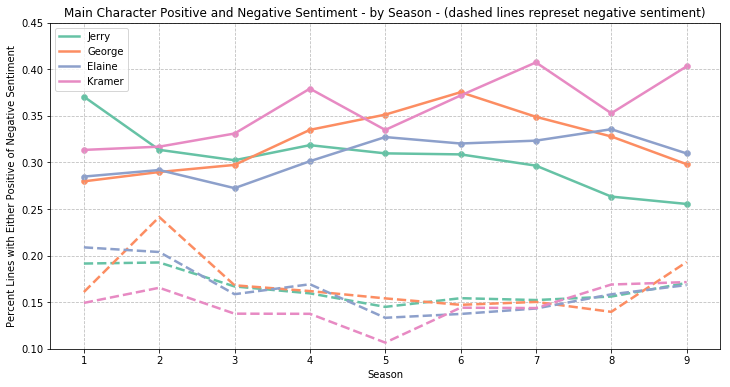

In [642]:
def plot_character_sentiment(df_sentiment_by_character):
    df = df_sentiment_by_character.copy()
    
    fig = plt.figure(figsize=(12,6))
    
    for character in main_characters:

        character_df = df[df['Character'] == character]
        x = character_df['Season']
        y_pos = character_df['Percent_Positive']
        y_neg = character_df['Percent_Negative']
        
        plt.scatter(x, y_pos, label='_nolegend_', color=main_char_colors[character], lw=0.5)
        plt.plot(x, y_pos, label=character.title(), color=main_char_colors[character], lw=2.5)
        plt.plot(x, y_neg, label='_nolegend_', 
                           color=main_char_colors[character], 
                           lw=2.5,
                           linestyle="--")


    plt.ylabel('Percent Lines with Either Positive of Negative Sentiment')
    plt.xlabel('Season')
    plt.legend(loc='upper left')
    plt.title('Main Character Positive and Negative Sentiment - by Season - (dashed lines represet negative sentiment)'
              , loc='center')
    plt.grid(linestyle="--", color=(0.75, 0.75, 0.75, 0.1))
    plt.ylim(0.1, 0.45)
    plt.show()

plot_character_sentiment(df_sentiment_by_character)